In [1]:
import os
import shutil

import numpy as np
import pandas as pd

from pathlib import Path
from rdkit import Chem
from tqdm import tqdm

In [2]:
import warnings
def warn(*args, **kwargs):
    pass
warnings.warn = warn

## Mahine learning methods

Machine learning methods are chosen from different families for diversity.

In [3]:
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor

In [4]:
ml_list = [(Ridge(), "RidgeRegression"), 
           (KNeighborsRegressor(), "KNeighborsRegressor"),
           (SVR(), "SVR"),
           (RandomForestRegressor(), "RandomForestRegressor"),
           (MLPRegressor(max_iter=500), "MLPRegressor"),
           ]

## Chemical descriptors

Descriptors are chosen from different families (topological, physico-chemical, tranformer-based, etc.) for diversity.

More descriptors: https://molfeat.datamol.io/featurizers

In [5]:
from molfeat.calc import (FPCalculator,
                          RDKitDescriptors2D, 
                          Pharmacophore2D, 
                          MordredDescriptors, 
                          CATS, 
                          ScaffoldKeyCalculator)

In [6]:
descr_list = [
            # fingerprints
            (FPCalculator("atompair"), "AtomPairBinary"),
            (FPCalculator("atompair-count"), "AtomPairCount"),
            (FPCalculator("avalon"), "AvalonBinary"),
            (FPCalculator("ecfp"), "ECFPBinary"),
            (FPCalculator("ecfp-count"), "ECFPCount"),
            (FPCalculator("erg"), "ERG"),
            (FPCalculator("estate"), "Estate"),
            (FPCalculator("fcfp"), "FCFPBinary"),
            (FPCalculator("fcfp-count"), "FCFPCount"),
            (FPCalculator("layered"), "Layered"),
            (FPCalculator("maccs"), "MACCS"),
            (FPCalculator("pattern"), "Pattern"),
            (FPCalculator("rdkit"), "RDKitBinary"),
            (FPCalculator("rdkit-count"), "RDKitCount"),
            (FPCalculator("secfp"), "SECFP"),
            (FPCalculator("topological"), "TopologicalBinary"),
            (FPCalculator("topological-count"), "TopologicalCount"),

            # long
            # (RDKitDescriptors2D(replace_nan=True), "RDKitDescriptors2D"),
            # (Pharmacophore2D(replace_nan=True), "Pharmacophore2D"),
            # (MordredDescriptors(replace_nan=True), "MordredDescriptors"),
            # (ScaffoldKeyCalculator(), "ScaffoldKey"),
           ]

## Run benchmark

In [7]:
from sklearn.preprocessing import MinMaxScaler

In [8]:
def parse_data(data_path):
    data = pd.read_csv(data_path, header=None)
    
    mol_prop_list = []
    for smi, prop in zip(data[0], data[1]):
        mol = Chem.MolFromSmiles(smi)
        mol_prop_list.append((mol, prop))

    return mol_prop_list

### Input/output data path

In [9]:
# input data
benchmark_collection =  Path("benchmark_collection_prepared").resolve()

# output data
prediction_collection = Path("benchmark_model_prediction").resolve()
if os.path.exists(prediction_collection):
    shutil.rmtree(prediction_collection)
    
os.makedirs(prediction_collection, exist_ok=True)

### Model building

In [10]:
total_num = sum([len(os.listdir(os.path.join(benchmark_collection, i))) for i in os.listdir(benchmark_collection)])

In [11]:
with tqdm(total=total_num) as progress_bar:
    
    for coll_folder in os.listdir(benchmark_collection):
        for bench_name in os.listdir(os.path.join(benchmark_collection, coll_folder)):
            
            # benchmark dataset
            bench_folder = os.path.join(benchmark_collection, coll_folder, bench_name)
            res_folder = os.path.join(prediction_collection, coll_folder, bench_name)
            os.makedirs(res_folder, exist_ok=True)
    
            # run benchmark 
            res_val = pd.DataFrame()
            res_test = pd.DataFrame()
            
            # parse dataset
            mols_train = parse_data(os.path.join(bench_folder, 'train.csv'))
            mols_val = parse_data(os.path.join(bench_folder, 'val.csv'))
            mols_test = parse_data(os.path.join(bench_folder, 'test.csv'))
            
            # save true prop
            res_val['Y_TRUE'] = [i[1] for i in mols_val]
            res_test['Y_TRUE'] = [i[1] for i in mols_test]
        
            # calc 2D descriptors
            for descr_func, descr_name in descr_list:
        
                # calculate training data descriptors
                x_train, y_train = [], []
                for mol, prop in mols_train:
                    if mol:
                        x_train.append(descr_func(mol))
                        y_train.append(prop)
                x_train = np.array(x_train)
                
                # scale training data descriptors
                scaler = MinMaxScaler()
                x_train_scaled = scaler.fit_transform(x_train)
                
                # train machine learning model
                for model, method_name in ml_list:
                    model.fit(x_train_scaled, y_train)
                    
                    # validation set prediction
                    y_pred = []
                    for mol in [i[0] for i in mols_val]:
                        if mol:
                            x_val = descr_func(mol)
                            x_val_scaled = scaler.transform(x_val.reshape(1, -1))
                            y_pred.append(model.predict(x_val_scaled).item())
                        else:
                            y_pred.append(np.mean(y_train))
                    #
                    res_val[f'{descr_name}|{method_name}'] = y_pred
                    res_val.to_csv(os.path.join(res_folder, f'{bench_name}_val.csv'), index=False)
    
                    # test set prediction
                    y_pred = []
                    for mol in [i[0] for i in mols_test]:
                        if mol:
                            x_test = descr_func(mol)
                            x_test_scaled = scaler.transform(x_test.reshape(1, -1))
                            y_pred.append(model.predict(x_test_scaled).item())
                        else:
                            y_pred.append(np.mean(y_train))
                    #
                    res_test[f'{descr_name}|{method_name}'] = y_pred
                    res_test.to_csv(os.path.join(res_folder, f'{bench_name}_test.csv'), index=False)
    
            # update progress bar
            progress_bar.update(1) 

  0%|▎                                                                             | 1/266 [18:13<80:31:44, 1093.98s/it]


KeyboardInterrupt: 

In [14]:
import datamol as dm
from molfeat.trans.fp import FPVecTransformer

In [35]:
mol = dm.to_mol("CN(C)C(=O)c1ccc(cc1)OC", ordered=True)
mol = dm.fix_mol(mol)
mol = dm.sanitize_mol(mol, sanifix=True, charge_neutral=False)
mol = dm.standardize_mol(
    mol,
    disconnect_metals=False,
    normalize=True,
    reionize=True,
    uncharge=False,
    stereo=True,
)

[14:09:37] WARNING: not removing hydrogen atom without neighbors
[14:09:37] Initializing Normalizer
[14:09:37] Running Normalizer


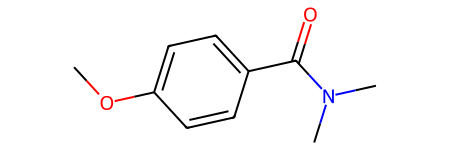

In [33]:
mol

In [37]:
from molfeat.trans.fp import FPVecTransformer, 

smiles = ["CN(C)C(=O)c1ccc(cc1)OC", "CS(=O)(=O)Cl", "CCc1cnccn1"]

transformer = FPVecTransformer(kind='fcfp-count', n_jobs=3, dtype=float)
features = transformer(smiles)

In [38]:
features

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(3, 2000))